In [1]:
"""
Script for plotting figures for a flow chart of processing methods

"""

#Define imports
from scipy.io import loadmat
from scipy import signal
import numpy as np
import time
import pyIGRF
import datetime
import pandas as pd
import matplotlib.pyplot as plt
#from wavesim1d import *
from src.em_apex_processing import *
from src.spectral_processing import *
import os
import warnings


#########################
Cmax=100
uVpc = 1e6 * (10e-3 / (2**24))

Nfit=2
nstep_off=5
navg_off=50
base_fr=0.02

ch=0.06
cz=0.09

nstep = 20 #
#Andy sets navg (spectrum time windowing) to 120
navg = 120 
Zmax=100
Dirmax=80
#electrode separation
esep1 = (8+5/8)*0.0254 # m
esep2 = (8+5/8)*0.0254 # m
c1 = 0.5
c2 = -0.2
# angles between compass and electrode axes
alpha2 = 1.95
alpha1 = alpha2 - np.pi/2

###########################


### Load Files ###
fname_base = "/Volumes/TFO-5TB-3/TFO/LCDRI/raw_data/"
#These 3 are hte good ones
#fname = "/Users/jamesstadler/Documents/UW/TFO/Data/LCDRI/test_efr/ema-6667i-0042-efr.mat"
#gpsfname = "/Users/jamesstadler/Documents/UW/TFO/Data/LCDRI/test_efr/ema-6667i-0042-gps.mat"
#ctdfname = "/Users/jamesstadler/Documents/UW/TFO/Data/LCDRI/test_efr/ema-6667i-0042-ctd.mat"
#This is a bad one
fname = "/Users/jamesstadler/Documents/UW/TFO/Data/LCDRI/test_efr/ema-6667i-0022-efr.mat"
gpsfname = "/Users/jamesstadler/Documents/UW/TFO/Data/LCDRI/test_efr/ema-6667i-0022-gps.mat"
ctdfname = "/Users/jamesstadler/Documents/UW/TFO/Data/LCDRI/test_efr/ema-6667i-0022-ctd.mat"
EFR = loadmat(fname)


efr_times = EFR['UXT'] - EFR['AGE']
efr_times = efr_times[0, :]
seqno = EFR['SEQNO'][0, :]

#Fit UXT times to sequence number (measurement # for that profile) to make sure monotonically increasing
p = np.polyfit(seqno,efr_times,1)
pfit = np.poly1d(p)
mlt_efr = pfit(seqno);

GPS = loadmat(gpsfname)
CTD = loadmat(ctdfname)


ctd_time = CTD["UXT"][0, :]
P = CTD["P"][0, :]
Pef = np.interp(mlt_efr, ctd_time, P)
#Pef = Pef-5

tim_pd = pd.to_datetime(GPS["UXT_GPS"][0, :],unit='s', utc=True,)
#Convert time to fractional year for use in the igrf function
frac_yrs = np.array([year_fraction(dt) for dt in tim_pd])
avg_lat = np.nanmean(GPS["LAT"][0, :])
avg_lon = np.nanmean(GPS["LON"][0, :])
avg_frac_yrs = np.nanmean(frac_yrs)

#Get magnetic field values
[Bx, By, Bz, f] = pyIGRF.calculate.igrf12syn(avg_frac_yrs, 1, 0, avg_lat, avg_lon)


fz=-np.nanmean(Bz);
fh=np.nanmean(np.sqrt(Bx**2+By**2));
sfv1 = 1e3/(fz*esep1*(1.0+c1));
sfv2 = 1e3/(fz*esep2*(1.0+c1));

#Convert from counts to microvolts
E1 = (EFR["E1"][0, :]-2**23) * uVpc;
E2 = (EFR["E2"][0, :]-2**23) * uVpc;

#pull out compass values
HZ = EFR["HZ"][0, :];
HY = EFR["HY"][0, :];
HX = EFR["HX"][0, :];

#Do the 50s fits 
[e1offs,e2offs,e1fits,e2fits,anghxhy, resid] = em_offset(Nfit,mlt_efr,nstep_off,navg_off,E1,E2,HX,HY);

#Get overall fi and calculate the residuals
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    e1off=np.nanmean(e1offs,1);
    e2off=np.nanmean(e2offs,1);
    e1fit=np.nanmean(e1fits,1);
    e2fit=np.nanmean(e2fits,1);

#Calculate the residual
e1r = E1 - e1fit
e2r = E2 - e2fit

#Now need to convert to velocity (m/s)
e1r = e1r*sfv1
e2r = e2r*sfv2


#Now use the angles to rotate to x-y coordinates
avg_angs = np.copy(anghxhy)
avg_angs[~np.isnan(avg_angs)] = np.unwrap(avg_angs[~np.isnan(avg_angs)])
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    avg_angs = np.nanmean(avg_angs, axis=1)


E2_r=e2r*np.cos(avg_angs)+e1r*np.sin(avg_angs);
E1_r=-e2r*np.sin(avg_angs)+e1r*np.cos(avg_angs);

E_x = E1_r*np.cos(alpha1)-E2_r*np.sin(alpha1)
E_y = E1_r*np.sin(alpha1)+E2_r*np.cos(alpha1)

#Now take the spectra
nblock = 120
fs = 1
[u_x, z_x] = reshape_u(E_x, Pef, nblock, 60, fs)

UUwindow, fwindow = make_vel_spectrum(u_x, fs)
#len(E_x.shape)
[u_y, z_y] = reshape_u(E_y, Pef, nblock, 60, fs)

[u_x_temp, t_new] = reshape_u(E_x, mlt_efr, nblock, 60, fs)
        
prof_speed = np.abs(z_x[:, 0]-z_x[:, -1])/np.abs(t_new[:, 0]-t_new[:, -1])

VVwindow, fwindow = make_vel_spectrum(u_y, fs)

 #Now try highpass filtering the data
sos = signal.butter(10, 0.03, 'hp', fs=1, output='sos')
E_x_filtered = signal.sosfilt(sos, E_x)
E_y_filtered = signal.sosfilt(sos, E_y)
[u_x, z_x] = reshape_u(E_x_filtered, Pef, nblock, 60, fs)

UUwindow, fwindow = make_vel_spectrum(u_x, fs)
len(E_x.shape)
[u_y, z_y] = reshape_u(E_y_filtered, Pef, nblock, 60, fs)

VVwindow, fwindow = make_vel_spectrum(u_y, fs)


UU = UUwindow/(int(nblock/2)*fs)
Exx = UU[:,1:]/ (np.square((2*np.pi*fwindow[1:])))
VV = UUwindow/(int(nblock/2)*fs)
Eyy = VV[:,1:]/ (np.square((2*np.pi*fwindow[1:])))

Eh = Exx+Eyy

[Eh_Eric1, Eh_Eric2, Eh_Eric3, Eh_Eric4] = depth_correct_Eric(Eh, fwindow[1:], z_x, prof_speed, nblock, 10000, fs)

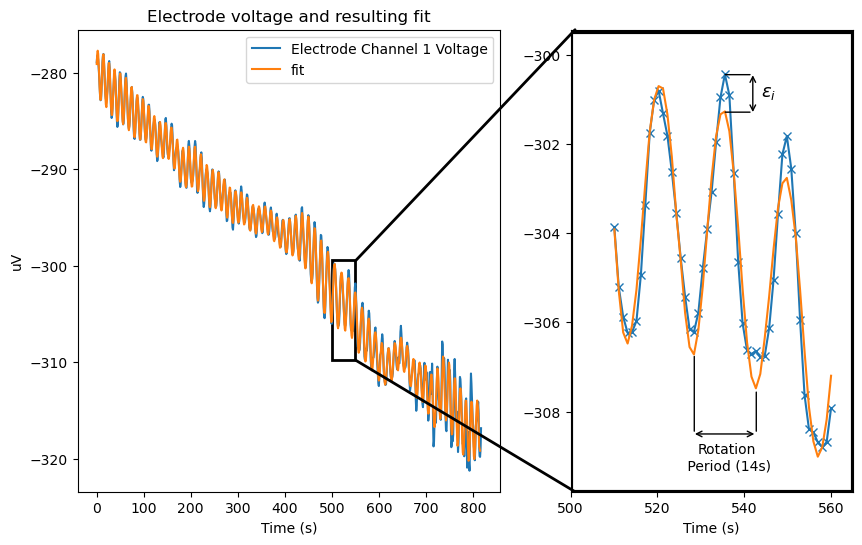

In [2]:
import matplotlib.patches as patches
from matplotlib.patches import ConnectionPatch


#lower bound for zoom in
lbound = 500
width = 50
f, (a0, a1) = plt.subplots(1, 2, figsize=(10, 6), gridspec_kw={'width_ratios': [1.5, 1]})

zoom_yliml = np.min(E1[lbound:lbound+width])-1
zoom_ylimu = np.max(E1[lbound:lbound+width])+1

rect = patches.Rectangle((lbound, zoom_yliml), width, zoom_ylimu-zoom_yliml, linewidth=2, edgecolor='k', facecolor='none')
a0.add_patch(rect)
a0.plot(mlt_efr - mlt_efr[0], E1, label='Electrode Channel 1 Voltage')
a0.plot(mlt_efr - mlt_efr[0], e1fit, label='fit')
#a01 = a0.twinx()
#a01.plot(mlt_efr - mlt_efr[0], E2, label='E2', color='r')
a0.legend()

a1.plot(mlt_efr[lbound:lbound+width] - mlt_efr[0], E1[lbound:lbound+width], '-x', label='Electrode Channel 1 Voltage')
a1.plot(mlt_efr[lbound:lbound+width] - mlt_efr[0], e1fit[lbound:lbound+width], label='fit')


xyl = (lbound+width+1, zoom_yliml)
xyr = (lbound+1, zoom_yliml)
con = ConnectionPatch(xyA=xyl, xyB=xyr, coordsA="data", coordsB="data",
                      axesA=a0, axesB=a1, color="k", linewidth=2)
xyl = (lbound+width+1, zoom_ylimu)
xyr = (lbound+1, zoom_ylimu)
con2 = ConnectionPatch(xyA=xyl, xyB=xyr, coordsA="data", coordsB="data",
                      axesA=a0, axesB=a1, color="k", linewidth=2)

a1.add_artist(con)
a1.add_artist(con2)

rect = patches.Rectangle((lbound, zoom_yliml), 65, zoom_ylimu-zoom_yliml-0.05, linewidth=3, edgecolor='k', facecolor='none')
a1.add_patch(rect)

a1.set_ylim(zoom_yliml, zoom_ylimu)
a1.set_xlim(500, 565)
a1.set_ylim(zoom_yliml, zoom_ylimu)
a1.set_xlabel("Time (s)")
#a1.arrow(530, -302, 0, 1, length_includes_head=True, head_width=1., head_length=0.5)
#Lines for residuals
a1.annotate(text='', xy=(542,-300.4), xytext=(542,-301.35), arrowprops=dict(arrowstyle='<->'))
a1.annotate(text='', xy=(535,-300.45), xytext=(542,-300.45), arrowprops=dict(arrowstyle='-'))
a1.annotate(text='', xy=(535,-301.29), xytext=(542,-301.29), arrowprops=dict(arrowstyle='-'))
a1.annotate(text=r'$\epsilon_{i}$', xy=(544,-300.93), fontsize=13)


#Lines for rotation period
a1.annotate(text='', xy=(528,-308.5), xytext=(543,-308.5), arrowprops=dict(arrowstyle='<->'))
a1.annotate(text='', xy=(528.5,-306.7), xytext=(528.5,-308.5), arrowprops=dict(arrowstyle='-'))
a1.annotate(text='', xy=(542.8,-307.5), xytext=(542.8,-308.5), arrowprops=dict(arrowstyle='-'))
a1.annotate(text='Rotation\n Period (14s)', xy=(536,-309.3), fontsize=10, ha="center")



# a1.plot(e2r, Pef)
# a1.yaxis.tick_right()
# a1.set_ylabel("Depth (m)")
# a1.set_xlabel("Velocity (m/s)")
# a1.yaxis.set_label_position("right")
# a1.invert_yaxis()




a0.set_xlabel("Time (s)")
a0.set_ylabel("uV")
a0.set_title("Electrode voltage and resulting fit")
#a1.set_title("Residuals")

f.savefig("/Users/jamesstadler/Documents/UW/TFO/Figures/LCDRI/JTECH_Paper/voltage_w_fit.png")

In [4]:
np.min(E1[lbound:lbound+width])

-308.79411101341236

Text(0, 0.5, 'channel 2 (uV)')

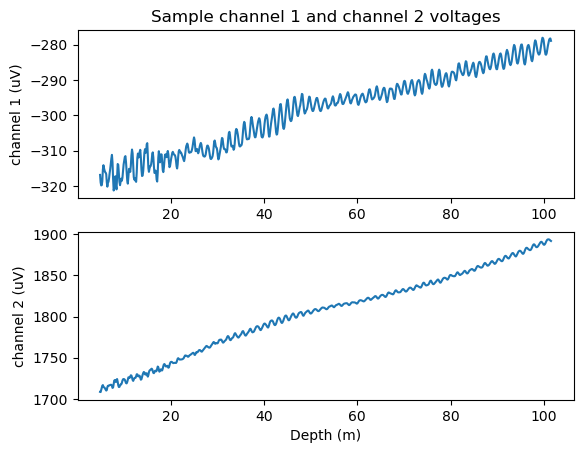

In [5]:
#np.nanmean(E1) - np.std(E1)*2
# Just plot channel voltages
plt.subplot(211)
plt.plot(Pef, E1)
plt.ylabel("channel 1 (uV)")
plt.title("Sample channel 1 and channel 2 voltages")
plt.subplot(212)
plt.plot(Pef, E2)
plt.xlabel("Depth (m)")
plt.ylabel("channel 2 (uV)")


Text(0.5, 1.0, "u' and v'")

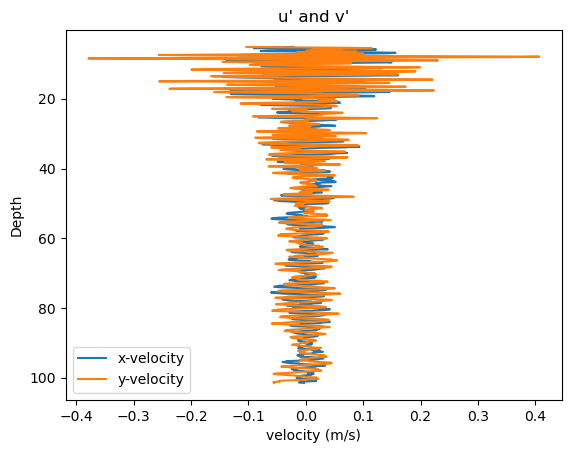

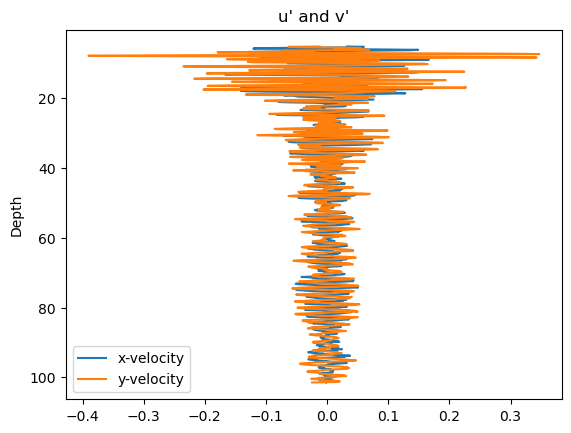

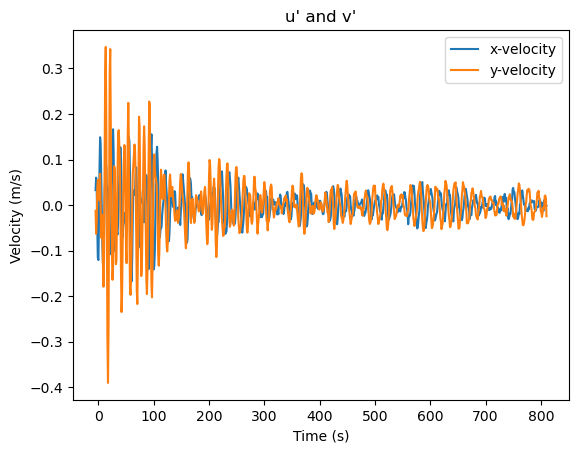

In [6]:
 #Now try highpass filtering the data
sos = signal.butter(10, 0.04, 'hp', fs=1, output='sos')
E_x_filtered = signal.sosfilt(sos, E_x)
E_y_filtered = signal.sosfilt(sos, E_y)

plt.figure()
plt.plot(E_x, Pef, label="x-velocity")
plt.plot(E_y, Pef, label='y-velocity')
plt.gca().invert_yaxis()
plt.legend()
plt.ylabel("Depth")
plt.title("u' and v'")
#plt.title("u")
#plt.xlabel("Residual velocity (m/s)")
plt.xlabel("velocity (m/s)")
#plt.savefig("/Users/jamesstadler/Documents/UW/TFO/Figures/1Hz_flowchart_figs/x_y_residuals.png")

plt.figure()
plt.plot(E_x_filtered, Pef, label="x-velocity")
plt.plot(E_y_filtered, Pef, label='y-velocity')
plt.gca().invert_yaxis()
plt.legend()
plt.ylabel("Depth")
plt.title("u' and v'")


plt.figure()
plt.plot(mlt_efr[0]-mlt_efr+810, E_x_filtered, label="x-velocity")
plt.plot(mlt_efr[0]-mlt_efr+810, E_y_filtered, label='y-velocity')
#plt.gca().invert_yaxis()
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.title("u' and v'")

Text(0.5, 1.0, "v'")

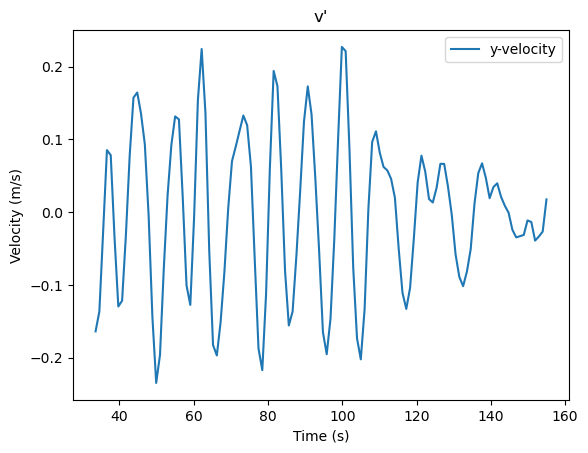

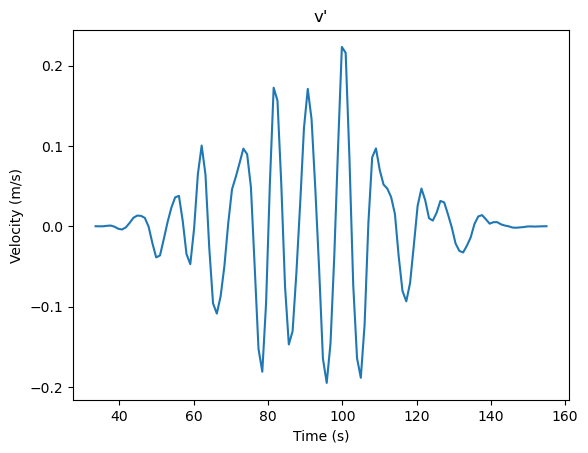

In [9]:
taper_in = np.linspace(1, 120, 120)*2*np.pi/120
taper_in = taper_in - np.pi
taper2 = np.cos(taper_in/2)*np.cos(taper_in/2)

plt.figure()
#plt.plot(mlt_efr[0]-mlt_efr[650:770]+len(mlt_efr)*1.02, E_x_filtered[650:770], label="x-velocity")
plt.plot(mlt_efr[0]-mlt_efr[650:770]+len(mlt_efr)*1.02, E_y_filtered[650:770], label='y-velocity')
#plt.gca().invert_yaxis()
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.title("v'")
#ax1 = plt.twinx()
#ax1.plot(mlt_efr[0]-mlt_efr[650:770]+len(mlt_efr)*1.02, taper2, color='green')
#plt.ylabel("Hanning window amplitude")


plt.figure()
plt.plot()
plt.plot(mlt_efr[0]-mlt_efr[650:770]+len(mlt_efr)*1.02, taper2*E_y_filtered[650:770], label='y-velocity')
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.title("v'")



/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_50906/1918753687.py:23: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.axvline(x=start, ymin=-3, ymax=3, LineStyle='--', color='gray')
/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_50906/1918753687.py:24: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.axvline(x=start+120, ymin=-3, ymax=3, LineStyle='--', color='gray')
/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_50906/1918753687.py:23: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.axvline(x=start, ymin=-3, ymax=3, LineStyle='--', color='gray')
/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_50906/1918753687.py:24: MatplotlibDeprecationWarning: Case-insensitive prope

Text(0, 0.5, 'Hanning window amplitude')

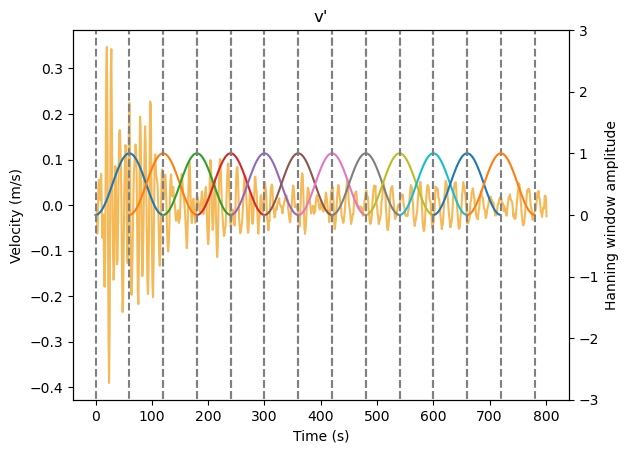

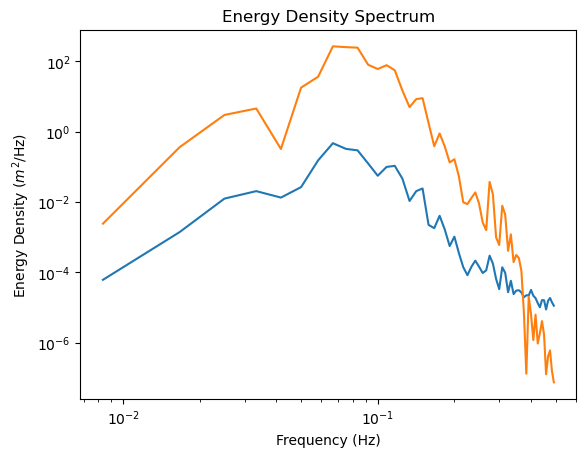

In [17]:
plt.figure()
plt.loglog(fwindow[1:], np.nanmean(Eh, axis=0))
plt.loglog(fwindow[1:], np.nanmean(Eh_Eric4, axis=0))
plt.xlabel("Frequency (Hz)")
plt.ylabel(r'Energy Density ($m^2$/Hz)')
plt.title("Energy Density Spectrum")
plt.savefig("/Users/jamesstadler/Documents/UW/TFO/Figures/1Hz_flowchart_figs/raw_spec_w_corr.png")



In [24]:
len(np.arange(0, 120))

120

Text(0.5, 1.0, 'Energy Density Spectrum')

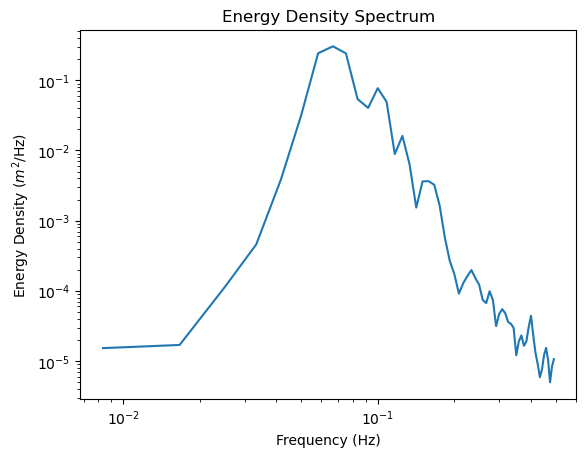

In [54]:
[u_x, z_x] = reshape_u(E_x_filtered, Pef, nblock, 60, fs)

UUwindow, fwindow = make_vel_spectrum(u_x, fs)
#len(E_x.shape)
[u_y, z_y] = reshape_u(E_y_filtered, Pef, nblock, 60, fs)

VVwindow, fwindow = make_vel_spectrum(u_y, fs)


UU = UUwindow/(int(nblock/2)*fs)
Exx = UU[:,1:]/ (np.square((2*np.pi*fwindow[1:])))
VV = UUwindow/(int(nblock/2)*fs)
Eyy = VV[:,1:]/ (np.square((2*np.pi*fwindow[1:])))

Eh = Exx+Eyy

plt.figure()
#plt.loglog(fwindow[1:], np.nanmean(Eh_Eric4, axis=0))
plt.loglog(fwindow[1:], np.nanmean(Eh, axis=0))

plt.xlabel("Frequency (Hz)")
plt.ylabel(r'Energy Density ($m^2$/Hz)')
plt.title("Energy Density Spectrum")
#plt.savefig("/Users/jamesstadler/Documents/UW/TFO/Figures/1Hz_flowchart_figs/raw_spec.png")



In [6]:
from scipy.io import netcdf

#Load CDIP Data
fname = "/Users/jamesstadler/Documents/UW/TFO/Data/LCDRI/229p1_d01.nc"
nc = netcdf.NetCDFFile(fname, 'r', mmap=False) #Not sure why I need to do mmap = False but it gets rid of a warning
cdip_time = nc.variables['waveTime'][:]
Hs_cdip = nc.variables['waveHs'][:]
energy_density = nc.variables['waveEnergyDensity'][:]
wave_freq = nc.variables['waveFrequency'][:]

Text(0.5, 1.0, 'Sample CDIP Wave Spectrum')

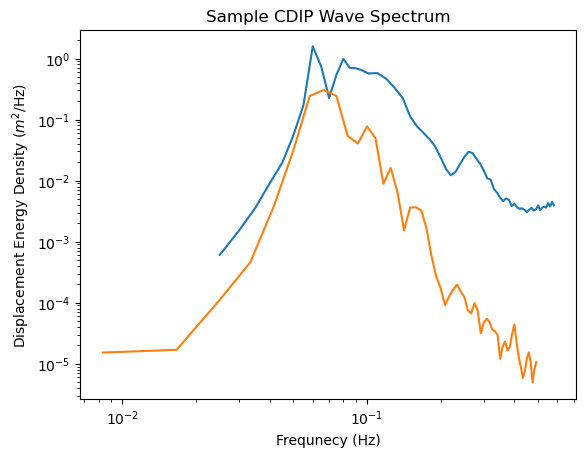

In [57]:
plt.loglog(wave_freq, np.nanmean(energy_density[100:110, :], axis=0))
plt.loglog(fwindow[1:], np.nanmean(Eh, axis=0))
plt.xlabel("Frequnecy (Hz)")
plt.ylabel(r"Displacement Energy Density ($m^2$/Hz)")
plt.title("Sample CDIP Wave Spectrum")
#plt.savefig("/Users/jamesstadler/Documents/UW/TFO/Figures/1Hz_flowchart_figs/sample_CDIP_spec.png")


In [3]:
"""
Process an up and a down adn save e1
"""


from scipy.io import loadmat, savemat
from scipy import signal
from scipy.io import netcdf
import numpy as np
import time
import pyIGRF
import datetime
import pandas as pd
import matplotlib.pyplot as plt
#from wavesim1d import *
from src.em_apex_processing import *
from src.spectral_processing import *
import os
import warnings
from scipy.stats import sem



#########################
#####Define Constants####
#########################
Cmax=10
uVpc = 1e6 * (10e-3 / (2**24))

#Degree of polynomial fit
Nfit=1

nstep_off=10
navg_off=50
base_fr=0.02

ch=0.06
cz=0.09

nstep = 10
navg = 50
Zmax=100
Dirmax=80
#electrode separation
esep1 = (8+5/8)*0.0254 # m
esep2 = (8+5/8)*0.0254 # m
c1 = 0.5
c2 = -0.2
# angles between compass and electrode axes
alpha2 = 1.95
alpha1 = alpha2 - np.pi/2
###########################


nblock = 120
fs = 1
overlap = 60

### Load Files ###
#For loading from harddrive
#fname_base = "/Volumes/TFO-5TB-3/TFO/LCDRI/raw_data/"
#For loading from laptop
fname_base = "/Users/jamesstadler/Documents/UW/TFO/Data/LCDRI/EmApex_Data/lcdri/"
save_dir = "/Volumes/TFO-5TB-3/TFO/LCDRI/processed_data/James_output/Spectra/"
float_list = os.listdir(fname_base)






up_count = 0
down_count = 0
up = True

float_id_counter = 0
ignore_count = 0
too_deep_counter = 0
min_bin = []
first_bot = []

##Testing for nans -- TO DO: Think we can delete this nan stuff
nancounter = 0
nanstorer = []
for float_id in float_list:
    if up_count==1 and down_count==1:
        break
    if "grid" in float_id:
        continue
    if ".DS_" in float_id:
        continue
        
    dec_name = fname_base+float_id+"/dec/"
    
    #Loop through each profile for that float
    files = os.listdir(dec_name)
    efr_files = [file for file in files if "efr.mat" in file and not file.startswith('.')]
    

    counter=0
    #Load each profiling file, and then calculate the 1D spectrum
    for file in efr_files:
        fname = dec_name + file
        EFR = loadmat(fname)

        
        prof_num = int(file.split('-')[2])
        #Load the UXT times, and correct
        
        efr_times = EFR['UXT'] - EFR['AGE']
        efr_times = efr_times[0, :]
        seqno = EFR['SEQNO'][0, :]
        
        #Fit UXT times to sequence number (measurement # for that profile) to make sure monotonically increasing
        p = np.polyfit(seqno,efr_times,1)
        pfit = np.poly1d(p)
        mlt_efr = pfit(seqno);

        
        #Load GPS file for calculating 
        # gps files are only on up profiles (even)
        if prof_num%2==0:
            up = True
            cut = fname.find("efr")
            gpsfname = fname[:cut]+"gps.mat"
            up_count=0
        else:
            up = False
            new_file = file.split('-')[0]+'-'+file.split('-')[1]+'-{:04d}'.format(prof_num+1)+'-gps.mat'
            gpsfname = dec_name+new_file
            down_count
        GPS = loadmat(gpsfname)

        #Load CTD file 
        cut = fname.find("efr")
        ctdfname = fname[:cut]+"ctd.mat"
        CTD = loadmat(ctdfname)
        
        ctd_time = CTD["UXT"][0, :]
        P = CTD["P"][0, :]
        Pef = np.interp(mlt_efr, ctd_time, P)

        tim_pd = pd.to_datetime(GPS["UXT_GPS"][0, :],unit='s', utc=True,)
        #Convert time to fractional year for use in the igrf function
        frac_yrs = np.array([year_fraction(dt) for dt in tim_pd])
        avg_lat = np.nanmean(GPS["LAT"][0, :])
        avg_lon = np.nanmean(GPS["LON"][0, :])
        avg_frac_yrs = np.nanmean(frac_yrs)

        #Get magnetic field values
        [Bx, By, Bz, f] = pyIGRF.calculate.igrf12syn(avg_frac_yrs, 1, 0, avg_lat, avg_lon)
        #get conversion factor for converting to velocity
        fz=-np.nanmean(Bz);
        fh=np.nanmean(np.sqrt(Bx**2+By**2));
        sfv1 = 1e3/(fz*esep1*(1.0+c1));
        sfv2 = 1e3/(fz*esep2*(1.0+c1));
        
        #Convert from counts to microvolts
        E1 = (EFR["E1"][0, :]-2**23) * uVpc;
        E2 = (EFR["E2"][0, :]-2**23) * uVpc;
        
        #pull out compass values
        HZ = EFR["HZ"][0, :];
        HY = EFR["HY"][0, :];
        HX = EFR["HX"][0, :];
        
        
        #If up is true, flip everything
        if up:
            E1 = np.flip(E1)
            E2 = np.flip(E2)
            HZ = np.flip(HZ)
            HX = np.flip(HX)
            HY = np.flip(HY)
            Pef = np.flip(Pef)
            mlt_efr = np.flip(mlt_efr)
        
        else:
            #Do Nothing
            pass
            
        
        #Remove the beginning of the timesereis before the float starts moving
        #Need to do this for all of E1, E2, HX, HY, mlt_efr
        moving_inds = get_moving_inds(Pef)
        

            
        #Apply moving_inds to the EM timeseries
        E1 = E1[moving_inds]
        E2 = E2[moving_inds]
        HX = HX[moving_inds]
        HY = HY[moving_inds]
        mlt_efr = mlt_efr[moving_inds]
        Pef = Pef[moving_inds]
        
        #[HX, HY] = correct_magnetometer(HX, HY)
        
        a,b = signal.butter(10, 0.04, 'hp', fs=1, analog=False)
        E1_filtered = signal.filtfilt(a, b, E1)
        E2_filtered = signal.filtfilt(a, b, E2)
        
        
        #Do the 50s fits 
        [e1offs,e2offs,e1fits,e2fits,anghxhy, resid] = em_offset(Nfit,mlt_efr,nstep_off,navg_off,E1,E2,HX,HY);

        
        #Try a 50s fit on the filtered data
        [e1offs_f,e2offs_f,e1fits_f,e2fits_f,anghxhy_f, resid_f] = em_offset(Nfit,mlt_efr,nstep_off,navg_off,E1_filtered,E2_filtered,HX,HY);

        
        #Get overall fi and calculate the residuals
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            e1off=np.nanmean(e1offs,1);
            e2off=np.nanmean(e2offs,1);
            e1fit=np.nanmean(e1fits,1);
            e2fit=np.nanmean(e2fits,1);
            resid = np.nanmean(resid,1);

        #Calculate the residual
        e1r = E1 - e1fit
        e2r = E2 - e2fit
        
        
        #Get overall fi and calculate the residuals
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            e1off_f=np.nanmean(e1offs_f,1);
            e2off_f=np.nanmean(e2offs_f,1);
            e1fit_f=np.nanmean(e1fits_f,1);
            e2fit_f=np.nanmean(e2fits_f,1);
            resid_f = np.nanmean(resid_f,1);

        #Calculate the residual
        e1r_f = E1_filtered - e1fit_f
        e2r_f = E2_filtered - e2fit_f
        
        

        E1tiled = np.tile(E1, (e1fits.shape[1], 1)).T
        E2tiled = np.tile(E2, (e1fits.shape[1], 1)).T
        
        e1r_mat = E1tiled - e1fits
        e2r_mat = E2tiled - e2fits

        
        E1tiled_f = np.tile(E1_filtered, (e1fits.shape[1], 1)).T
        E2tiled_f = np.tile(E2_filtered, (e1fits.shape[1], 1)).T
        
        e1r_mat_f = E1tiled - e1fits_f
        e2r_mat_f = E2tiled - e2fits_f

        
        ## Do spike detection
        #If either channel has spikes, ignore the profile.
        spikes=contains_spikes(E1, E2)
        if spikes:
            print(fname)
            continue
        
        
        #Now need to convert to velocity (m/s)
        e1r = e1r*sfv1
        e2r = e2r*sfv2
        
        e1r_f = e1r_f*sfv1
        e2r_f = e2r_f*sfv2
        
        e1r_mat = e1r_mat*sfv1
        e2r_mat = e2r_mat*sfv2
        
        e1r_mat_f = e1r_mat_f*sfv1
        e2r_mat_f = e2r_mat_f*sfv2
        
#         e1r_max = np.nanmax(e1r_mat, axis=1)
#         e2r_max = np.nanmax(e2r_mat, axis=1)
#         e1r_min = np.nanmin(e1r_mat, axis=1)
#         e2r_min = np.nanmin(e2r_mat, axis=1)
        
        
        #Now use the angles to rotate to x-y coordinates
        avg_angs = np.copy(anghxhy)
        anghxhy[~np.isnan(anghxhy)] =  np.unwrap(avg_angs[~np.isnan(anghxhy)])
        avg_angs[~np.isnan(avg_angs)] = np.unwrap(avg_angs[~np.isnan(avg_angs)])
        
        avg_angs_f = np.copy(anghxhy_f)
        anghxhy_f[~np.isnan(anghxhy_f)] =  np.unwrap(avg_angs_f[~np.isnan(anghxhy_f)])
        avg_angs_f[~np.isnan(avg_angs_f)] = np.unwrap(avg_angs_f[~np.isnan(avg_angs_f)])


        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            avg_angs = np.nanmean(avg_angs, axis=1)
            avg_angs_f = np.nanmean(avg_angs_f, axis=1)
            

        E2_r=e2r*np.cos(avg_angs)+e1r*np.sin(avg_angs)
        E1_r=-e2r*np.sin(avg_angs)+e1r*np.cos(avg_angs)
        
        E_x = E1_r*np.cos(alpha1)-E2_r*np.sin(alpha1)
        E_y = E1_r*np.sin(alpha1)+E2_r*np.cos(alpha1)
        
        
        E2_r_f=e2r_f*np.cos(avg_angs_f)+e1r_f*np.sin(avg_angs_f)
        E1_r_f=-e2r_f*np.sin(avg_angs_f)+e1r*np.cos(avg_angs_f)
        
        E_x_f = E1_r_f*np.cos(alpha1)-E2_r_f*np.sin(alpha1)
        E_y_f = E1_r_f*np.sin(alpha1)+E2_r_f*np.cos(alpha1)
        
        
        #Now try highpass filtering the data
        sos = signal.butter(10, 0.04, 'hp', fs=1, output='sos')
        E_x_filtered = signal.sosfilt(sos, E_x)
        E_y_filtered = signal.sosfilt(sos, E_y)
        
        E_x_u = E_x
        E_y_u = E_y
        
        E_x = E_x_filtered
        E_y = E_y_filtered
        
        #Do the same for the matrix
        E2_r_mat = e2r_mat*np.cos(anghxhy)+e1r_mat*np.sin(anghxhy)
        E1_r_mat = -e2r_mat*np.sin(anghxhy)+e1r_mat*np.cos(anghxhy)
        
        E_x_mat = E1_r_mat*np.cos(alpha1)-E2_r_mat*np.sin(alpha1)
        E_y_mat = E1_r_mat*np.sin(alpha1)+E2_r_mat*np.cos(alpha1)
        
        E_x_mat_filtered = signal.sosfilt(sos, E_x_mat)
        E_y_mat_filtered = signal.sosfilt(sos, E_y_mat)
        
        #E_x_err = np.square(E_x_mat - np.tile(E_x, (E_x_mat.shape[1], 1)).T)
        #E_y_err = np.square(E_y_mat - np.tile(E_y, (E_y_mat.shape[1], 1)).T)
        
        E_x_err = E_x_mat - np.tile(E_x_u, (E_x_mat.shape[1], 1)).T
        E_y_err = E_y_mat - np.tile(E_y_u, (E_y_mat.shape[1], 1)).T
        

        
        #Now take the spectra

        
        #in the case where the float doesn't actually move for nblock measurements, need to skip it
        if len(E_x)<nblock:
            continue
        #If there's only one block worth of data, ignore the profile
        
      
        [u_x, z_x] = reshape_u(E_x, Pef, nblock, overlap, fs)
        [u_y, z_y] = reshape_u(E_y, Pef, nblock, overlap, fs)
        
#         [u_x_max, z_x] = reshape_u(E_x_max, Pef, nblock, overlap, fs)
#         [u_y_max, z_y] = reshape_u(E_y_max, Pef, nblock, overlap, fs)
        
#         [u_x_min, z_x] = reshape_u(E_x_min, Pef, nblock, overlap, fs)
#         [u_y_min, z_y] = reshape_u(E_y_min, Pef, nblock, overlap, fs)
        #prof_speed is a numpy array that stores the mean vertical velocity (in m/s)
        #for each spectral window
        #Throwaway to get t_new in the same shape as u_x and z_x for calculating mean profiling speed
        [u_x_temp, t_new] = reshape_u(E_x, mlt_efr, nblock, overlap, fs)
        
        prof_speed = np.abs(z_x[:, 0]-z_x[:, -1])/np.abs(t_new[:, 0]-t_new[:, -1])
        
        #if up:
        #    print(np.nanmean(prof_speed), "up")
        #else:
        #    print(np.nanmean(prof_speed), "down")
            
        if u_x.shape[0]==1:
            continue
        prof_speed_new = np.zeros(len(prof_speed))
        for block_ind in range(z_x.shape[0]):
            prof_speed_try = np.abs(np.gradient(z_x[block_ind, :], t_new[block_ind, :]))
            z_inds = prof_speed_try<0.001
            prof_speed_try[z_inds]=np.nan
            prof_speed_removed_zeros = np.nanmean(prof_speed_try)
            prof_speed_new[block_ind]=prof_speed_removed_zeros

        prof_speed = prof_speed_new
        
            
        #Get teh rotation frequency
        time_s = np.abs(mlt_efr - mlt_efr[0])
        rad_per_s = np.gradient(avg_angs, time_s) #radians per second. rotation period is 2pi/rad_per_s
        rotf = rad_per_s/2/np.pi
        
        [rotf_reshaped, _] = reshape_u(rotf, Pef, nblock, overlap, fs)
        
        window_rotf = np.nanmean(rotf_reshaped, axis=1)
        
        
        zero_inds = np.where(prof_speed==0)[0]
        #if len(zero_inds)>0:
            #print(z_x[0, :])
            
        UUwindow, fwindow = make_vel_spectrum(u_x, fs)
        VVwindow, fwindow = make_vel_spectrum(u_y, fs)
        
#         UUwindow_max, fwindow = make_vel_spectrum(u_x_max, fs)
#         VVwindow_max, fwindow = make_vel_spectrum(u_y_max, fs)
        
#         UUwindow_min, fwindow = make_vel_spectrum(u_x_min, fs)
#         VVwindow_min, fwindow = make_vel_spectrum(u_y_min, fs)

        min_z = np.min(Pef)
            
        if min_z>20:
            too_deep_counter+=1
        else:  
            min_bin = np.append(min_bin, min_z)
            first_bot = np.append(first_bot, z_x[0, -1])

            UU = UUwindow/(int(nblock/2)*fs)
            Exx = UU[:,1:]/ (np.square((2*np.pi*fwindow[1:])))
            VV = VVwindow/(int(nblock/2)*fs)
            Eyy = VV[:,1:]/ (np.square((2*np.pi*fwindow[1:])))
            Eh = Exx+Eyy
            
#             UU_max = UUwindow_max/(int(nblock/2)*fs)
#             Exx_max = UU_max[:,1:]/ (np.square((2*np.pi*fwindow[1:])))
#             VV_max = VVwindow_max/(int(nblock/2)*fs)
#             Eyy_max = VV_max[:,1:]/ (np.square((2*np.pi*fwindow[1:])))
#             Eh_max = Exx_max+Eyy_max
            
#             UU_min = UUwindow_min/(int(nblock/2)*fs)
#             Exx_min = UU_min[:,1:]/ (np.square((2*np.pi*fwindow[1:])))
#             VV_min = VVwindow_min/(int(nblock/2)*fs)
#             Eyy_min = VV_min[:,1:]/ (np.square((2*np.pi*fwindow[1:])))
#             Eh_min = Exx_min+Eyy_min
           
                
            [Eh_Eric1, Eh_Eric2, Eh_Eric3, Eh_Eric4] = depth_correct_Eric(Eh, fwindow[1:], z_x, prof_speed, nblock, Cmax, fs)
#             [Eh_Eric1, Eh_Eric2, Eh_Eric3, Eh_Eric4_max] = depth_correct_Eric(Eh_max, fwindow[1:], z_x, prof_speed, nblock, Cmax, fs)
#             [Eh_Eric1, Eh_Eric2, Eh_Eric3, Eh_Eric4_min] = depth_correct_Eric(Eh_min, fwindow[1:], z_x, prof_speed, nblock, Cmax, fs)
            #G1 = Eh_Eric2/Eh_Eric1
            #G2 = Eh_Eric3/Eh_Eric2
           # G3 = Eh_Eric4/Eh_Eric3
        
            
            u_noise = 0 #This is just for testing...
            [lbound, ubound, nu] = get_spectral_uncertainity(E_x, E_y, Pef, u_noise, prof_speed, nblock, overlap, Cmax, fs)
            #print(lbound)
            #print(ubound)
            #Try propogating errors through and see if this has a different result
            #Eh_lbound = Eh*lbound
            #Eh_ubound = Eh*ubound
            
            
            if up:
                Eh_up = Eh
                Eh_corr_up = Eh_Eric4
                E1_up = E1
                E2_up = E2
                Pef_up = Pef
                rotf_up = rotf
                
            else:
                Eh_down = Eh
                Eh_corr_down = Eh_Eric4
                E1_down = E1
                E2_down = E2
                Pef_down = Pef
                rotf_down = rotf
        
        
            counter+=1
        
        
        

    
    float_id_counter+=1
        
    #np.save(save_dir+float_id, spec_store)

/Users/jamesstadler/Documents/UW/TFO/Data/LCDRI/EmApex_Data/lcdri/6667i/dec/ema-6667i-0062-efr.mat


/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_28724/2826181954.py:377: RuntimeWarning: Mean of empty slice
  prof_speed_removed_zeros = np.nanmean(prof_speed_try)
/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_28724/2826181954.py:377: RuntimeWarning: Mean of empty slice
  prof_speed_removed_zeros = np.nanmean(prof_speed_try)


/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_28724/1035036489.py:59: RuntimeWarning: Mean of empty slice
  plt.loglog(fwindow[1:],np.nanmean(Eh_corr_up, axis=0), color=red_color)
/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_28724/1035036489.py:60: RuntimeWarning: Mean of empty slice
  plt.loglog(fwindow[1:],np.nanmean(Eh_corr_down, axis=0), color=gray_color)


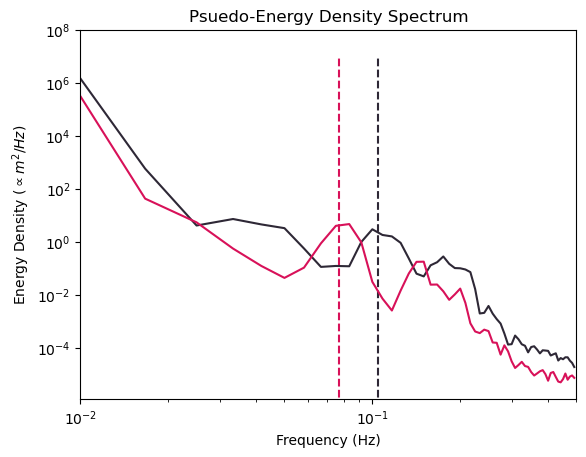

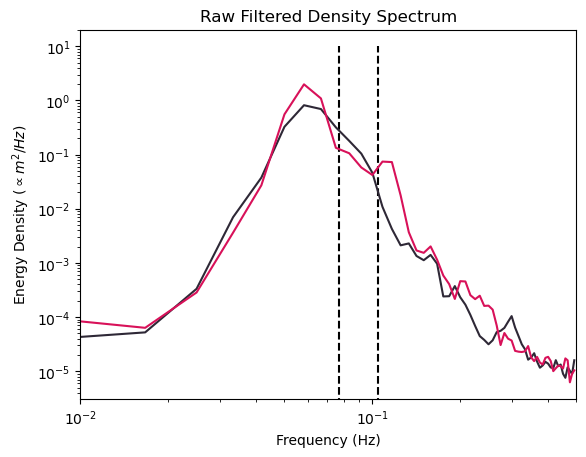

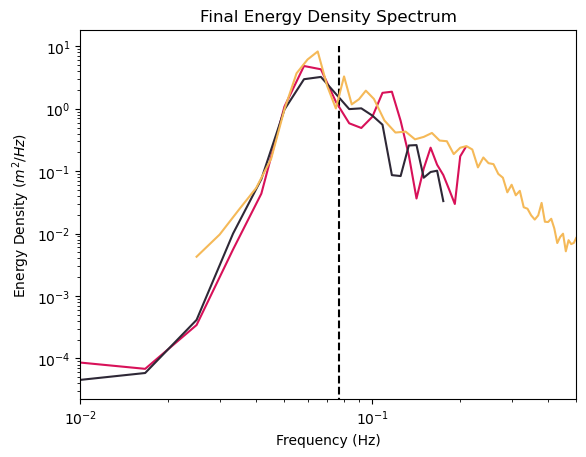

In [7]:
##Plot the flowchart of velocity processing

cdip_color='#F5B958'
red_color = '#D81159'
gray_color= '#2E2836'

#Get time
float_time = np.nanmean(mlt_efr)
cdip_ind = np.where(np.abs(cdip_time-float_time)==np.min(np.abs(cdip_time-float_time)))
[u_x, z_x] = reshape_u(E1_up, Pef_up, nblock, overlap, fs)
[u_y, z_y] = reshape_u(E2_up, Pef_up, nblock, overlap, fs)

[UUwindow, fwindow] = make_vel_spectrum(u_x, 1)
[VVwindow, fwindow] = make_vel_spectrum(u_y, 1)

UU = UUwindow/(int(120/2)*1)
Exx = UU[:,1:]/ (np.square((2*np.pi*fwindow[1:])))
VV = VVwindow/(int(120/2)*1)
Eyy = VV[:,1:]/ (np.square((2*np.pi*fwindow[1:])))
Eh_pseudo_up = Exx+Eyy


[u_x, z_x] = reshape_u(E1_down, Pef, nblock, overlap, fs)
[u_y, z_y] = reshape_u(E2_down, Pef, nblock, overlap, fs)

[UUwindow, fwindow] = make_vel_spectrum(u_x, 1)
[VVwindow, fwindow] = make_vel_spectrum(u_y, 1)

UU = UUwindow/(int(120/2)*1)
Exx = UU[:,1:]/ (np.square((2*np.pi*fwindow[1:])))
VV = VVwindow/(int(120/2)*1)
Eyy = VV[:,1:]/ (np.square((2*np.pi*fwindow[1:])))
Eh_pseudo_down = Exx+Eyy

plt.loglog(fwindow[1:],np.nanmean(Eh_pseudo_down, axis=0), color=gray_color)
plt.loglog(fwindow[1:],np.nanmean(Eh_pseudo_up, axis=0), color=red_color)
plt.vlines(x=np.nanmean(rotf_down), ymin=0, ymax=10**7, color=gray_color, linestyle='--', label="Rotation Frequency")
plt.vlines(x=np.nanmean(rotf_up), ymin=0, ymax=10**7, color=red_color, linestyle='--', label="Rotation Frequency")
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"Energy Density ($\propto m^2/Hz$)")
plt.title("Psuedo-Energy Density Spectrum")
plt.xlim([0.01, 0.5])

plt.figure()
plt.loglog(fwindow[1:],np.nanmean(Eh_down, axis=0), color=gray_color)
plt.loglog(fwindow[1:],np.nanmean(Eh_up, axis=0), color=red_color)


plt.vlines(x=np.nanmean(rotf_up), ymin=0, ymax=10, color='k', linestyle='--', label="Rotation Frequency")
plt.vlines(x=np.nanmean(rotf_down), ymin=0, ymax=10, color='k', linestyle='--', label="Rotation Frequency")


plt.xlabel("Frequency (Hz)")
plt.ylabel(r"Energy Density ($\propto m^2/Hz$)")
plt.title("Raw Filtered Density Spectrum")
plt.xlim([0.01, 0.5])

plt.figure()
plt.loglog(fwindow[1:],np.nanmean(Eh_corr_up, axis=0), color=red_color)
plt.loglog(fwindow[1:],np.nanmean(Eh_corr_down, axis=0), color=gray_color)


plt.vlines(x=np.nanmean(rotf), ymin=0, ymax=10, color='k', linestyle='--', label="Rotation Frequency")
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"Energy Density ($m^2/Hz$)")
plt.title("Final Energy Density Spectrum")
plt.xlim([0.01, 0.5])
plt.loglog(wave_freq, energy_density[cdip_ind[0], :].T, color=cdip_color, label="")



In [44]:
all_swift_file = "/Users/jamesstadler/Documents/UW/TFO/Data/LCDRI/SWIFT/testswiftnew.mat"

SWIFT_new = loadmat(all_swift_file)
swift_arr = np.array([[0,0,0,0,0,0,0]])
spec_array = np.array([])
for i in range(len(SWIFT_new['swift'][0, 0])):
    lat_arr = np.array([])
    lon_arr = np.array([])
    swift_temp = SWIFT_new['swift'][0, 0][i]
    #time = swift_temp[0, 0][0][0]
    #lon = swift_temp[0, 0][1][0]
    #lat = swift_temp[0, 0][2][0]
    #wavesigH = swift_temp[0, 0][9][0]
    mdtype = swift_temp.dtype
    ndata = {n: swift_temp[n] for n in mdtype.names}
    columns = [n for (n, v) in ndata.items()]
    df = pd.DataFrame(np.concatenate([ndata[c] for c in columns], axis=1, dtype='object'), columns=columns)
    lat=np.array(df['lat'][0], dtype=float).T
    lon=np.array(df['lon'][0], dtype=float).T
    time = np.array(df['time'][0], dtype=float).T
    hs = np.array(df['wavesigH'][0], dtype=float).T
    wave_dir = np.array(df['wavepeakdir'][0], dtype=float).T
    peak_T = np.array(df['wavepeakT'][0], dtype=float).T
    #lat_arr = np.expand_dims(lat, axis=1)
    #lon_arr = np.expand_dims(lon, axis=1)
    #time_arr = np.expand_dims(time, axis=1)
    #hs_arr = np.expand_dims(hs, axis=1)

    wave_spec = swift_temp['wavepower'][0, 0]
    #wave_spec[np.where(np.isnan(wave_spec))] = 0
    if len(spec_array) == 0:
        spec_array = wave_spec.T
    else:
        spec_array = np.vstack((spec_array, wave_spec.T))
    
    start_f = 0.03
    cutoff_freq = 0.5

    swift_freq = swift_temp['wavefreq'][0, 0][:, 0]
    end_f = np.where(swift_freq<cutoff_freq)[-1][-1]
    start_f = np.where(swift_freq>start_f)[0][0]
    spec_t = wave_spec[start_f:end_f].T
    swift_freq_t = swift_freq[start_f:end_f]
    #spec_t[np.where(np.isnan(spec_t))] = 0
    
    #swift_freq_t = np.tile(swift_freq_t
    #swift_freq_t = np.tile(swift_freq_t, (spec_t.shape[0], 1))
    Te_temp = np.array([])
    for spec_i in range(spec_t.shape[0]):
        Te_temp = np.append(Te_temp, np.trapz(spec_t[spec_i, ~np.isnan(spec_t[spec_i, :])], x=swift_freq_t[~np.isnan(spec_t[spec_i, :])])/np.trapz(swift_freq_t[~np.isnan(spec_t[spec_i, :])]*spec_t[spec_i, ~np.isnan(spec_t[spec_i, :])], x=swift_freq_t[~np.isnan(spec_t[spec_i, :])]))
    #Te_swift_store = np.append(Te_swift_store, Te_temp)
    Te_temp = np.expand_dims(Te_temp, (1))
    swift_temp_arr = np.hstack((time, lon, lat, hs, wave_dir, peak_T, Te_temp))
    swift_arr = np.vstack((swift_arr, swift_temp_arr))

    
swift_arr = np.delete(swift_arr, 0, 0)

#swift_arr2=swift_arr2[swift_arr[:, 0].argsort()]
spec_arr = spec_array[swift_arr[:, 0].argsort()]
swift_arr = swift_arr[swift_arr[:, 0].argsort()]
#spec_array = spec_array[swift_arr[:, 0].argsort()]

/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_28724/79316033.py:40: RuntimeWarning: Mean of empty slice
  ax3.loglog(fwindow[1:],np.nanmean(Eh_corr_up, axis=0), color=red_color, label="Up profile")
/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_28724/79316033.py:41: RuntimeWarning: Mean of empty slice
  ax3.loglog(fwindow[1:],np.nanmean(Eh_corr_down, axis=0), color=gray_color, label="Down profile")
/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_28724/79316033.py:59: RuntimeWarning: Mean of empty slice
  mean_swift_spec = np.nanmean(spec_arr[blah, :], axis=0)


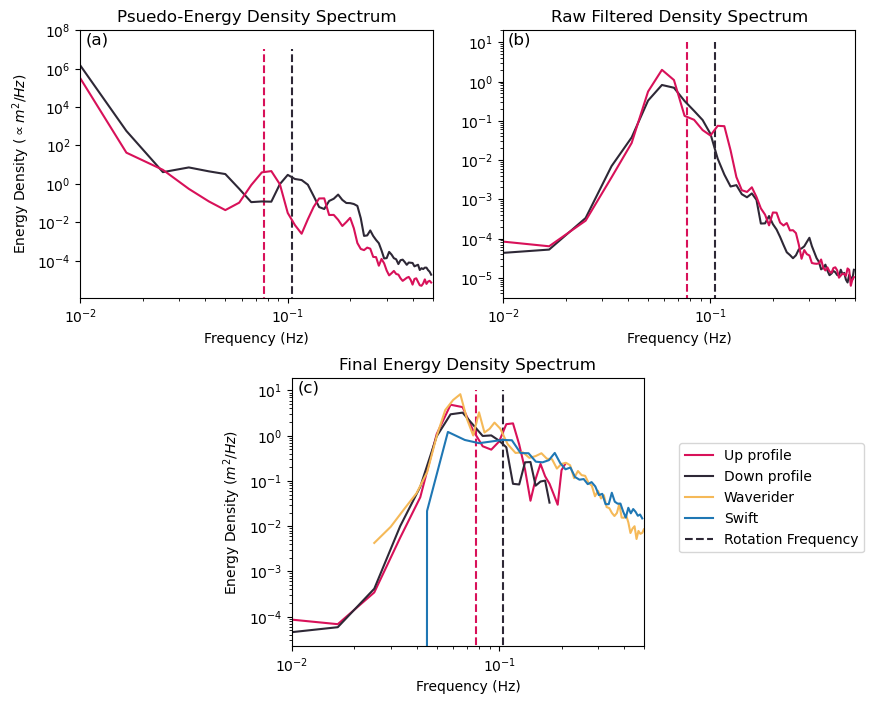

In [55]:
import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(2, 4)
gs.update(wspace=0.5)
gs.update(hspace=0.3)
plt.figure(figsize=(10,8))
ax1 = plt.subplot(gs[0, :2])
ax2 = plt.subplot(gs[0, 2:])
ax3 = plt.subplot(gs[1, 1:3])
#plt.show()

ax1.loglog(fwindow[1:],np.nanmean(Eh_pseudo_down, axis=0), color=gray_color)
ax1.loglog(fwindow[1:],np.nanmean(Eh_pseudo_up, axis=0), color=red_color)
ax1.vlines(x=np.nanmean(rotf_down), ymin=0, ymax=10**7, color=gray_color, linestyle='--', label="Rotation Frequency")
ax1.vlines(x=np.nanmean(rotf_up), ymin=0, ymax=10**7, color=red_color, linestyle='--', label="Rotation Frequency")
ax1.set_xlabel("Frequency (Hz)")
ax1.set_ylabel(r"Energy Density ($\propto m^2/Hz$)")
ax1.set_title("Psuedo-Energy Density Spectrum")
ax1.set_xlim([0.01, 0.5])
ax1.annotate(text='(a)', xy=(0.012, 1.8*10**7), fontsize=12, ha="center")



ax2.loglog(fwindow[1:],np.nanmean(Eh_down, axis=0), color=gray_color)
ax2.loglog(fwindow[1:],np.nanmean(Eh_up, axis=0), color=red_color)


ax2.vlines(x=np.nanmean(rotf_up), ymin=0, ymax=10, color=red_color, linestyle='--', label="Rotation Frequency")
ax2.vlines(x=np.nanmean(rotf_down), ymin=0, ymax=10, color=gray_color, linestyle='--', label="Rotation Frequency")


ax2.set_xlabel("Frequency (Hz)")
#ax2.set_ylabel(r"Energy Density ($\propto m^2/Hz$)")
ax2.set_title("Raw Filtered Density Spectrum")
ax2.set_xlim([0.01, 0.5])
ax2.annotate(text='(b)', xy=(0.012, 9), fontsize=12, ha="center")




ax3.loglog(fwindow[1:],np.nanmean(Eh_corr_up, axis=0), color=red_color, label="Up profile")
ax3.loglog(fwindow[1:],np.nanmean(Eh_corr_down, axis=0), color=gray_color, label="Down profile")


ax3.vlines(x=np.nanmean(rotf_up), ymin=0, ymax=10, color=red_color, linestyle='--')
ax3.vlines(x=np.nanmean(rotf_down), ymin=0, ymax=10, color=gray_color, linestyle='--', label="Rotation Frequency")
ax3.set_xlabel("Frequency (Hz)")
ax3.set_ylabel(r"Energy Density ($m^2/Hz$)")
ax3.set_title("Final Energy Density Spectrum")
ax3.set_xlim([0.01, 0.5])
ax3.loglog(wave_freq, energy_density[cdip_ind[0], :].T, color=cdip_color, label="Waverider")


ax3.annotate(text='(c)', xy=(0.012, 9), fontsize=12, ha="center")

#Get swift shit
swift_dtime = datenum_to_datetime(swift_arr[:, 0])
apex_dtime = datetime.datetime.fromtimestamp(np.nanmean(mlt_efr))
blah = np.where(np.abs(apex_dtime-swift_dtime)<datetime.timedelta(hours=0.5))[0]
mean_swift_spec = np.nanmean(spec_arr[blah, :], axis=0)
#mean_swift_spec.shape
ax3.loglog(swift_freq, mean_swift_spec, label="Swift")


plt.legend(loc=(1.1,0.35))
plt.savefig("/Users/jamesstadler/Documents/UW/TFO/Figures/LCDRI/JTECH_Paper/spectral_flowchart.png")


In [52]:
blah

array([1816, 1817, 1818, 1819, 1820, 1821, 1822, 1823, 1824, 1825, 1826,
       1827, 1828, 1829, 1830, 1831, 1832, 1833, 1834, 1835])

In [47]:
spec_arr[1, :] == spec_array[1, :]

array([False,  True,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False])

In [48]:
spec_array[blah[0], :]==spec_arr[blah[0], :]


array([[False,  True,  True, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False],
       [False,  True,  True, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False]])

In [20]:
spec_array[blah, :].shape

(1, 20, 42)

In [37]:
blah

(array([1826, 1827]),)

In [40]:
blah

(array([1826, 1827]),)